# Contents:
- Data preparation
- K-means Clusterisation of stations occupancy for weekdays and for weekends
- Interactive Leaflet maps of Dublin w/ stations coloured according to clusterisation
- Rebalancing peak detection 
- Reading weather data, making categorical and dummy weather features from text
- Estimating arrival and departure Poisson intensity rates
- UNDER RECONSTRUCTION: recreating unobserved demand for Dublinbikes using rate estimates

- Simulation
- Predicting actual demand by observed occupancy for simulation; rmse
- Training ML models
- More fancy graphs

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f2f2f2'
%matplotlib inline

import os
import re
import json
import urllib
import datetime

# custom module with helper functions

import bss_functions

# reload:
#from importlib import reload
#reload(bss_functions)

# Data preparation

In [31]:
# Read the data number of bikes at each station

data = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'bikes' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            data = pd.concat([data, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(data, 'data', n_obs, n_dropped)


    Collected data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [32]:
# Delete the stations for which the data wasn't always available

del data['CHATHAM_STREET'], data['CLARENDON_ROW'], data['JAMES_STREET_EAST']

# Read coordinates of bicycle stations

stations = pd.read_csv('./data/station_locations.csv')
stations['Name'] = stations.Name.apply(lambda x: x.replace("'", ""))

# Calculate elevation of each station
# altitudes = [bss_functions.altitude(stations.Latitude[i], stations.Longitude[i]) for i in range(stations.shape[0])]

# Load pre-calculated elevation of each station

import pickle
f = open('./data/altitudes.dat', 'rb')
altitudes = pickle.load(f)
stations['Alt'] = altitudes

# Calculate capacity (the number of locks at each station)

capacity = pd.DataFrame({'Name': data.T.index.values, 'Capacity': data.max(0)})
capacity.Name = capacity.Name.apply(lambda x: x.replace('_', ' ').replace("'", ""))
stations = stations.merge(capacity, on = 'Name', how = 'inner')

# plot elevation of each station using custom function

#bss_functions.plot_elevation_map(stations, stations.Latitude, stations.Longitude, stations.Name, stations.Alt)

# Patterns of use: weekdays vs weekends

In [33]:
# Build up a time series of each station averaged over weekdays and weekends

df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
df_copy['date'] = df_copy.index.date
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)
weekends = df_copy.loc[df_copy['weekday'] >= 5].drop(['weekday'], 1)
holidays = [datetime.date(2017, y, x) for [y, x] in zip([3, 4, 5, 6, 8], [17, 17, 1, 5, 7])]
for i in holidays:
    weekdays.drop(weekdays.index[weekdays.index.date == i], 0, inplace=True)    

# Resample by 5 min and backfill nans

weekdays = weekdays.resample('5T').mean().bfill()
weekends = weekends.resample('5T').mean().bfill() 

# Group by minute of day and take average for each station

weekdays['time'] = weekdays.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekdays = weekdays.groupby('time').agg('mean').astype(int)
weekends['time'] = weekends.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekends = weekends.groupby('time').agg('mean').astype(int)

# Normalise each station between 0 and 1 as each station has different capacity
weekdays_norm = weekdays / weekdays.max()
weekends_norm = weekends / weekends.max()

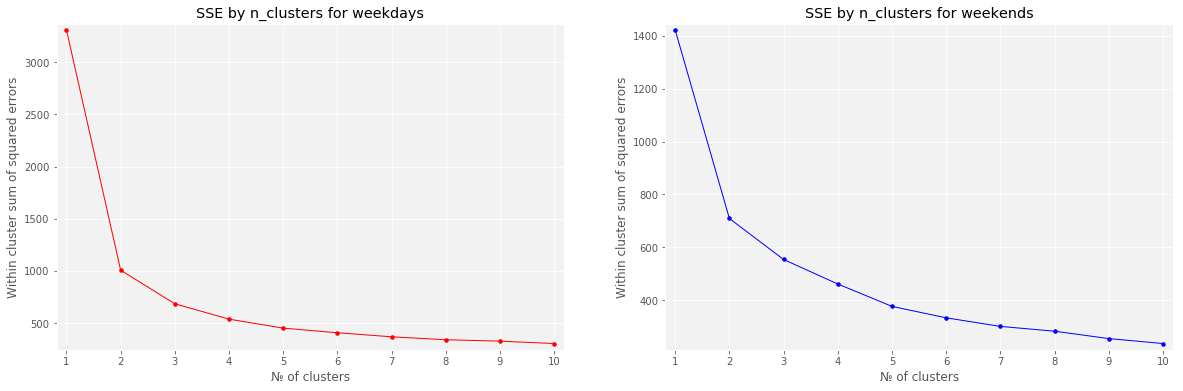

In [34]:
# Choose a suitable number of clusters using elbow method (mostly to support the intuition)
# 3 clusters can be selected both for the weekdays and weekends

bss_functions.plot_SSE(weekdays_norm, weekends_norm)

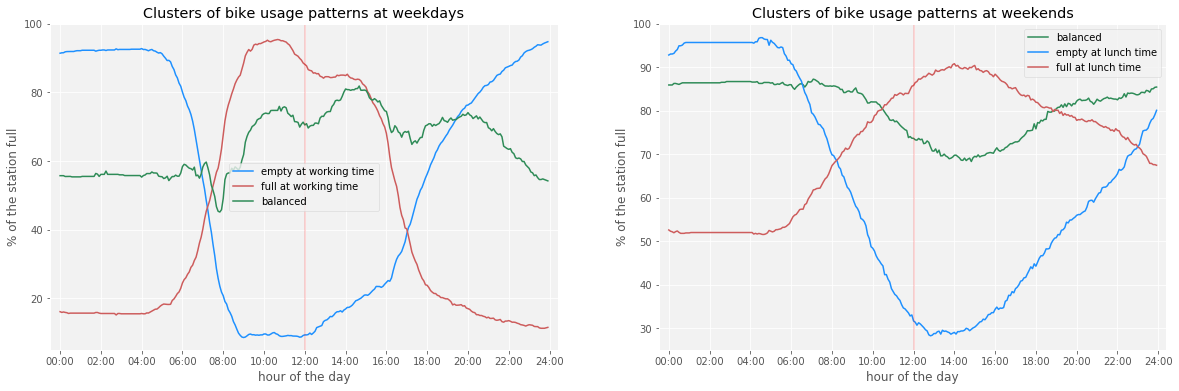

In [35]:
# K-means clustering to detect patterns in bike usage during weekdays and weekends
cluster_colours_wd = ['dodgerblue', 'indianred', 'seagreen']
cluster_colours_we = ['seagreen', 'dodgerblue', 'indianred']
clusters_weekdays, clusters_weekends = bss_functions.plot_cluster_usage_patterns(weekdays_norm, 
                                                                                 weekends_norm, 
                                                                                 cluster_colours_wd,
                                                                                 cluster_colours_we)


In [36]:
# Color stations based on their weekday usage pattern
# if the map is not rendering in Chrome, see clusters_wd_map.html in the project folder

folium_map = bss_functions.plot_clusters_map(stations, weekdays_norm, 
                                           clusters_array=clusters_weekdays, 
                                           cluster_colours=cluster_colours_wd)
folium_map.save('weekdays_map.html')
folium_map

In [37]:
# Color stations based on their weekend usage pattern
# if the map is not rendering in Chrome, see clusters_we_map.html in the project folder


#folium_map_1 = bss_functions.plot_clusters_map(stations, weekends_norm, 
#                                           clusters_array=clusters_weekends, 
#                                           cluster_colours=cluster_colours_we)
#folium_map_1.save('weekends_map.html')
#folium_map_1

# Some examples of different patterns of use

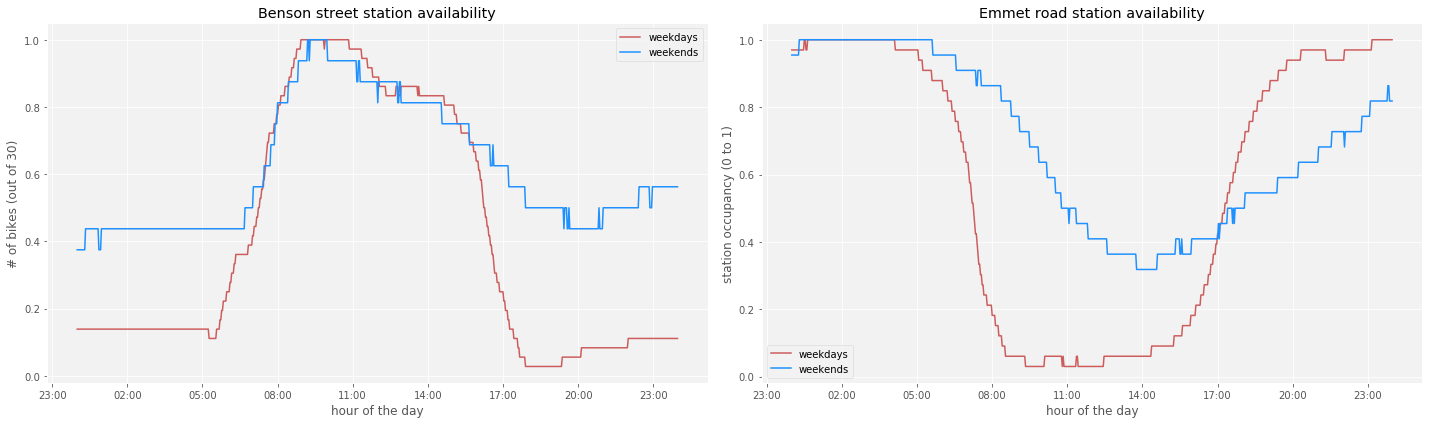

In [38]:
# BENSON_STREET: near the U2 tower; probably many people are working on Sat and Sun too, so no shift
# EMMET_ROAD: outskirts of the city

bss_functions.plot_usage_examples(data, 'BENSON_STREET', 'EMMET_ROAD')

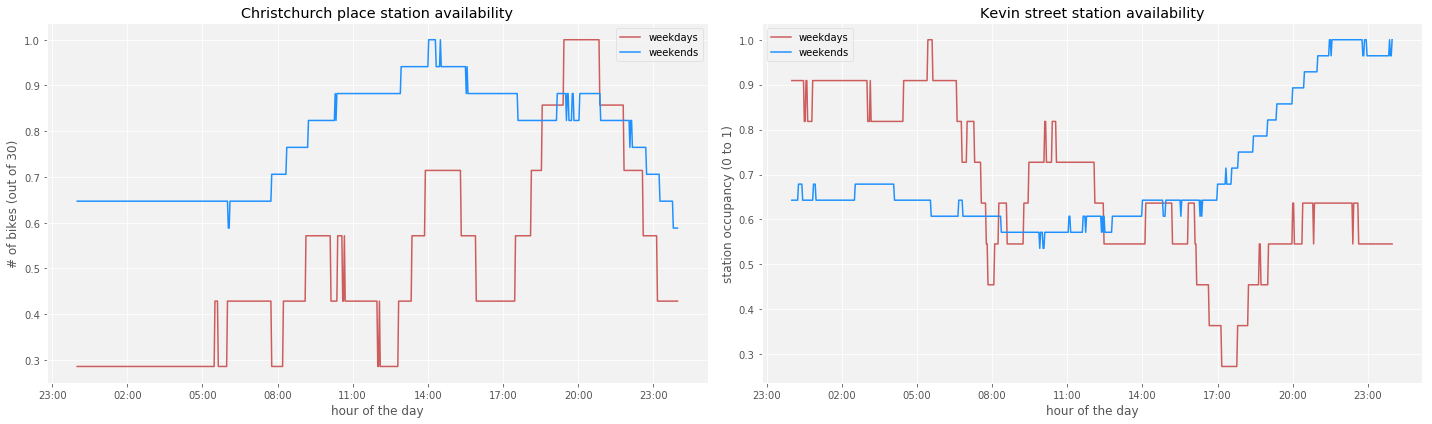

In [39]:
# CHRISTCHURCH_PLACE: tourist attractions nearby (Christ Church cathedral, Dublin Castle, Radisson Blu hotel)
# KEVIN_STREET: Dublin Institute of Technology => used by students

bss_functions.plot_usage_examples(data, 'CHRISTCHURCH_PLACE', 'KEVIN_STREET')

# Rebalancing peak detection

In [40]:
# Keep warm months and no precipitations

df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
df_copy['date'] = df_copy.index.date
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)
weekends = df_copy.loc[df_copy['weekday'] >= 5].drop(['weekday'], 1)
holidays = [datetime.date(2017, 3, 17), datetime.date(2017, 4, 17), datetime.date(2017, 5, 1), datetime.date(2017, 6, 5), datetime.date(2017, 8, 7)]
for i in holidays:
    weekdays.drop(weekdays.index[weekdays.index.date == i], 0, inplace=True)    
for i in [1,2,3,4]:
    weekdays.drop(weekdays.index[weekdays.index.month == i], 0, inplace=True) 

In [41]:
pb_weekdays = weekdays['PORTOBELLO_ROAD']
pb_weekdays_df = pd.DataFrame(pb_weekdays)
pb_weekdays_df['downward_peak'] = np.zeros(pb_weekdays_df.shape[0])
pb_weekdays_df['upward_peak'] = np.zeros(pb_weekdays_df.shape[0])
days = np.unique(pb_weekdays_df.index.date)

In [42]:

def expand_downward_peak(indices):
    '''
    this function recieves indices of high downward peaks that are suspected to be caused
    by rebalancing trucks, expands them, i.e. unites them with neighbouring differences if 
    their have co-directional dynamics and checks if each peak suits the pattern of Assumption 1.
    
    returns only indices of those downward peaks that are believed to be caused by rebalancing
    
    '''
    new_indices = []
    for ind in indices:
        ind_temp = [ind]
        i = 0
        while diff[ind-i] <= 0:
            ind_temp = np.append(ind_temp, ind-i-1)
            i += 1
        i = 0
        while diff[ind+i+1] <= 0:
            ind_temp = np.append(ind_temp, ind+i+1)
            i += 1
        if day.iloc[min(ind_temp)]-day.iloc[max(ind_temp)] <= 20 and day.iloc[min(ind_temp)]-day.iloc[max(ind_temp)] >= 5 and day.iloc[max(ind_temp)] >= 1 and (np.mean(day.iloc[max(ind_temp)+1:max(ind_temp)+20]) > day.iloc[max(ind_temp)]): 
            new_indices.append(ind_temp)
    try: new_indices = np.unique([x for subset in new_indices for x in subset])  
    except: pass
    new_indices.sort()
    return new_indices

def expand_upward_peak(indices):
    '''
    this function recieves indices of high upward peaks that are suspected to be caused
    by rebalancing trucks, expands them, i.e. unites them with neighbouring differences 
    if their have co-directional dynamics and checks if each peak suits the pattern of Assumption 1.
    
    returns only indices of those upward peaks that are believed to be caused by rebalancing
    
    '''
    new_indices = []
    for ind in indices:
        ind_temp = [ind]
        i = 0
        while diff[ind-i] >= 0:
            ind_temp = np.append(ind_temp, ind-i-1)
            i += 1
        i = 0
        while diff[ind+i+1] >= 0:
            ind_temp = np.append(ind_temp, ind+i+1)
            i += 1
        if day.iloc[max(ind_temp)]-day.iloc[min(ind_temp)] <= 20 and day.iloc[max(ind_temp)]-day.iloc[min(ind_temp)] >= 5 and day.iloc[max(ind_temp)] <= day.max()-1 and (np.mean(day.iloc[max(ind_temp):max(ind_temp)+20]) < day.iloc[max(ind_temp)] or np.mean(day.iloc[min(ind_temp)-5:min(ind_temp)]) < 1): 
            new_indices.append(ind_temp)
    try: new_indices = np.unique([x for subset in new_indices for x in subset])  
    except: pass
    new_indices.sort()
    return new_indices

# Finding suspicious high peaks using rolling mean of first differences, then inputing their
# indices in expand functions; each index that is believed to belong to a rebalancing peak
# gets a positive value (1 or 2) in upward_peak or downward_peak column as opposed to 0s

for i in days:
    day = pb_weekdays[pb_weekdays.index.date == i]
    diff = day.diff()
    rs = diff.rolling(3, center = False).sum()
    indices = np.hstack([np.where(diff < -7)[0], np.where(rs <= -7)[0]])
    try: index_last = np.where(rs <= -7)[0][-1]
    except: pass
    indices = [x for subset in [indices, [index_last]] for x in subset]
    indices = expand_downward_peak(indices)
    for j in indices:
        pb_weekdays_df.loc[day.index[j], 'downward_peak'] = 1
    try: 
        index_last_down = indices[-1]
    except: pass
    try:
        inds = np.append(indices[np.where(np.diff(indices) > 1)], index_last_down)
    except:
        inds = indices[np.where(np.diff(indices) > 1)]
    for j in inds:
        pb_weekdays_df.loc[day.index[int(j)], 'downward_peak'] = 2           
    indices = np.hstack([np.where(diff > 7)[0], np.where(rs >= 7)[0]])
    try: index_last_1 = np.where(rs >= 7)[0][-1]
    except: pass
    indices = [x for subset in [indices, [index_last_1]] for x in subset]
    indices = expand_upward_peak(indices)
    for j in indices:
        pb_weekdays_df.loc[day.index[j], 'upward_peak'] = 1
    try: index_last_up = indices[-1]
    except: pass
    inds = np.append(indices[np.where(np.diff(indices) > 1)], index_last_up)
    for j in inds:
        pb_weekdays_df.loc[day.index[int(j)], 'upward_peak'] = 2

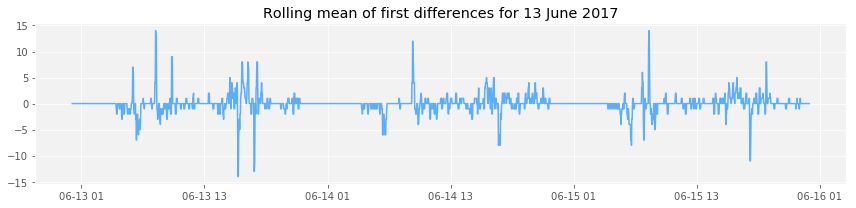

In [43]:
M = 6
D = 13
fig = plt.figure(figsize=(12,3))
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)

M = 6
D = 14
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)

M = 6
D = 15
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)
plt.title('Rolling mean of first differences for 13 June 2017')
fig.savefig('rollingmeandiff.png')
plt.tight_layout()
plt.show()

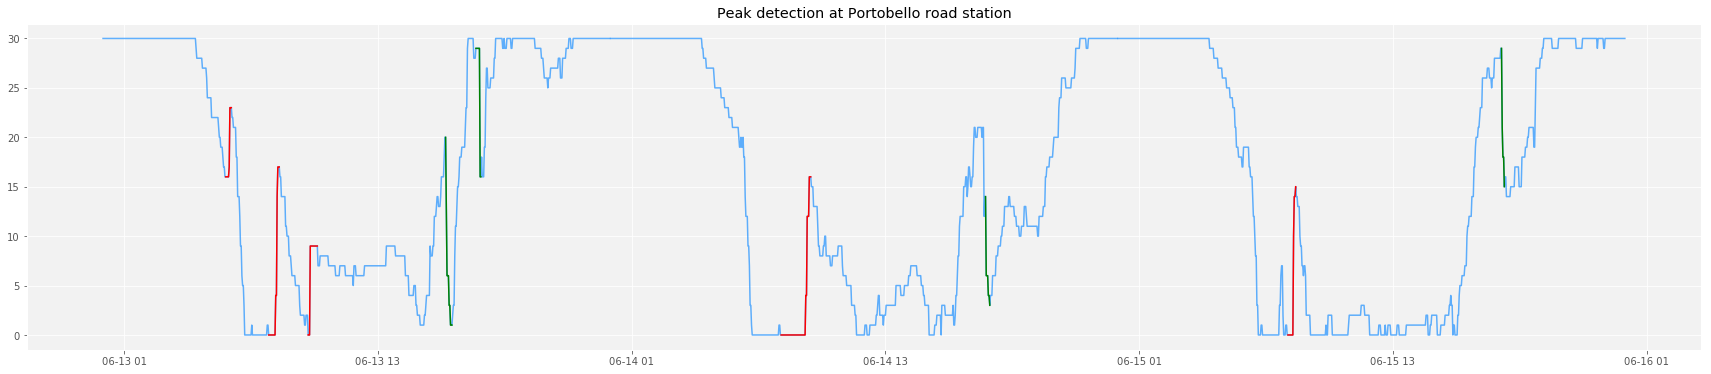

In [44]:
fig = plt.figure(figsize=(30,6))
M = 6
D = 13

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')
plt.title('Peak detection at Portobello road station')

M = 6
D = 14

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')

    
M = 6
D = 15

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')

fig.savefig('peak_detection.png')

plt.show()

# Read and transform weather data

In [45]:
# Read the data collected from weather.com

weather = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'weather' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            weather = pd.concat([weather, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(weather, 'weather data', n_obs, n_dropped)


    Collected weather data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [46]:
# Feature engineering

# Create dummy features from text description of the weather, then add intensity factor

weather = bss_functions.get_weather_features(weather)

# Resample by 1 min and interpolate with mean

features = pd.DataFrame({'Temperature': weather.resample('1T')['Temperature'].mean().interpolate(),
                          'Feels_Like': weather.resample('1T')['Feels_Like'].mean().interpolate(),
                          'Wind_Speed': weather.resample('1T')['Wind_Speed'].mean().interpolate(),
                          'Snow': weather.resample('1T')['Snow'].mean().interpolate(),
                          'Rain': weather.resample('1T')['Rain'].mean().interpolate(),  
                          'Clouds': weather.resample('1T')['Clouds'].mean().interpolate(),
                          'Fog': weather.resample('1T')['Fog'].mean().interpolate(),
                          'Thunder': weather.resample('1T')['Thunder'].mean().interpolate(),
                          'Hail': weather.resample('1T')['Hail'].mean().interpolate(), 
                                })

# Add categorical variable denoting month and dummy variables denoting season

features = bss_functions.get_seasonal_features(features)
features.head(3)

,Clouds,Feels_Like,Fog,Hail,Rain,Snow,Temperature,Thunder,Wind_Speed,Month,Spring,Summer,Winter
Time,,,,,,,,,,,,,
2017-01-24 00:00:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:01:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:02:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1


# Estimating arrival and departure rates
### (# of events per hour) for different steps of piecewise-constant Poisson processes; graphs for Portobello road

- red graph shows rates estimated ignoring the fact that at certain times the rates can't be observed due to station capacity census.

- blue graph shows rates estimated by the adjusted formula observing only that part of each time interval where calculated rate can be observed, i.e. it was not completely full or empty for arrival and departure rates calculation, respectively

the rates do not count rebalancing peaks

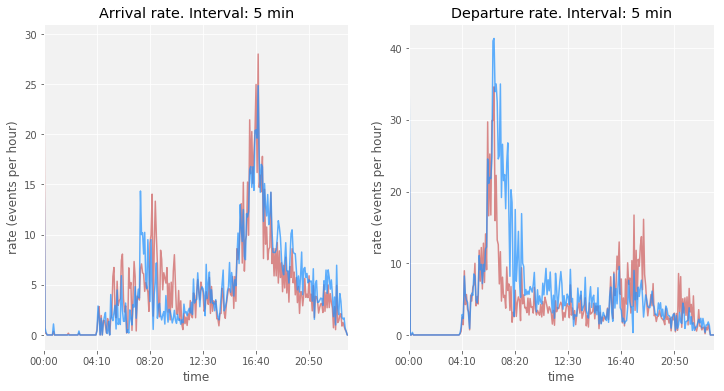

In [47]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=5)

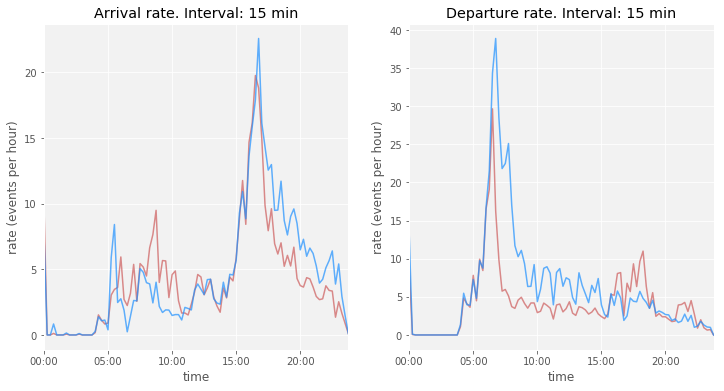

In [67]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=15)

In [68]:
import pickle
f = open('rates.dat', 'wb')
pickle.dump(ar_adj, f)
pickle.dump(dep_adj, f)
f.close()

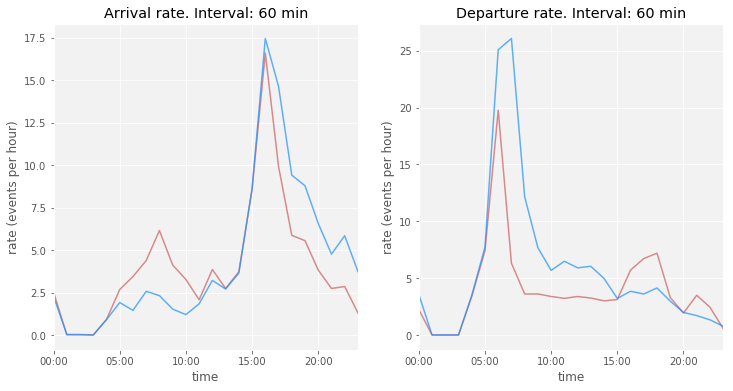

In [50]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=60)

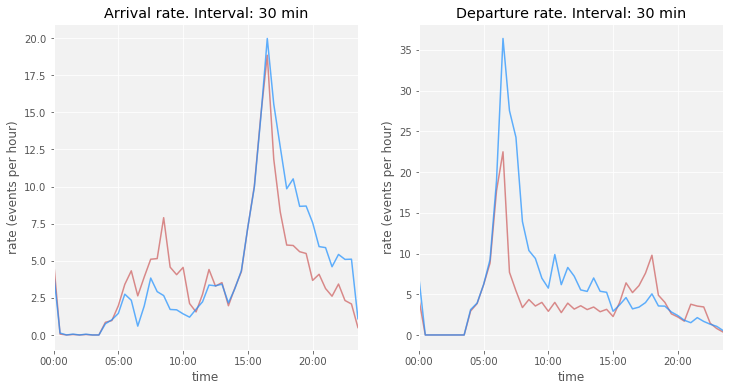

In [51]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=30)

# Using estimates to predict unobserved demand

In [69]:
ar_adj.index = pd.to_datetime(ar_adj.index)
ar_adj = ar_adj.resample('2T').mean().interpolate()
dep_adj.index = pd.to_datetime(dep_adj.index)
dep_adj = dep_adj.resample('2T').mean().interpolate()

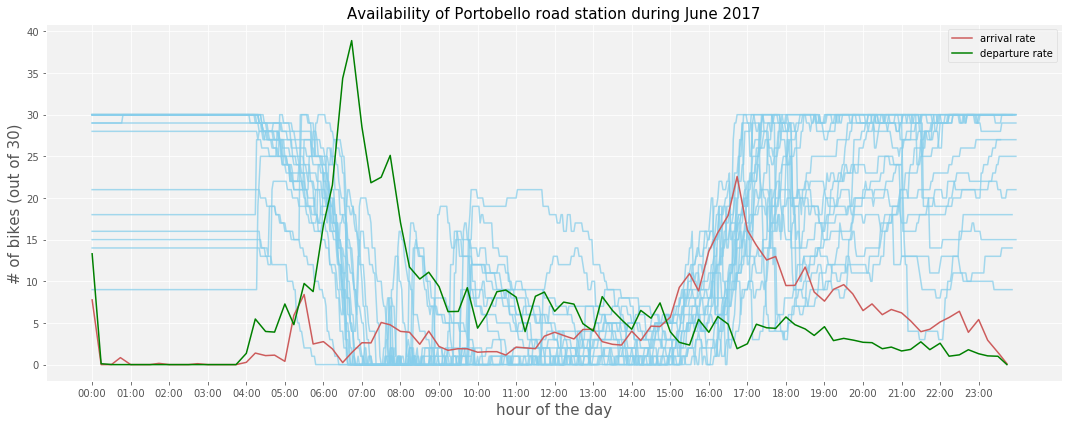

In [70]:
data['DATE'] = [x.date() for x in data.index]
data.columns = [x.replace("'",'') for x in data.columns.values]
weekdays['DATE'] = [x.date() for x in weekdays.index]
range_ = range(1, 31)
colors = ['skyblue']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(15, 6))

for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.75, color = col,label='_nolegend_')
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(15)
axis_weekdays.yaxis.label.set_fontsize(15)

plt.title('Availability of Portobello road station during June 2017')
axis_weekdays.title.set_fontsize(15)
#dep_adj = -dep_adj + 30
axis_weekdays.plot(ar_adj.values, 'indianred', alpha = 1, label = 'arrival rate')
axis_weekdays.plot(dep_adj.values, 'g', alpha = 1, label = 'departure rate')

axis_weekdays.legend()

figure.savefig('june_availability.png')
plt.tight_layout()
plt.show()

In [71]:
ar_adj.index = ar_adj.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
dep_adj.index = dep_adj.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))

day = pb_weekdays_df[pb_weekdays_df.index.date == datetime.date(2017, 7, 17)][['PORTOBELLO_ROAD', 'peak']]
day = day.resample('2T').mean().bfill()

pb_weekdays_df['peak'] = pb_weekdays_df.downward_peak + pb_weekdays_df.upward_peak
pb = pb_weekdays_df[['PORTOBELLO_ROAD', 'peak']]
pb = pb.resample('2T').mean().bfill()
ind = pb.index
pb = np.array(pb)
pb_new = []
for i in range(int(pb.shape[0]/720)):
    day = pb[720*i:720*(i+1)]
    shift = 0
    for x in range(720):
        pb_new.append(day[x][0]-shift)
        if day[x][1] != 0:
            shift += day[x+1][0]-day[x][0]

# Simulation

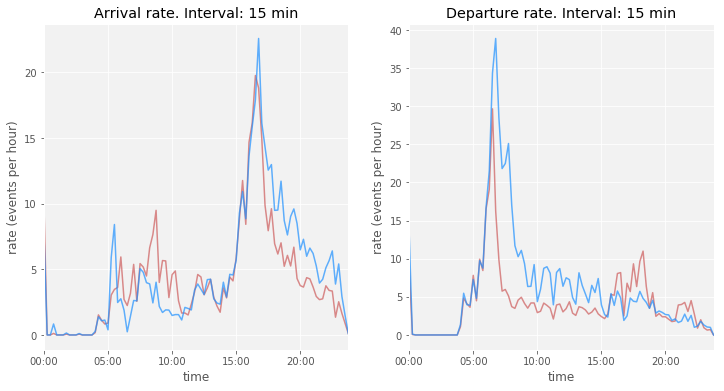

In [72]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=15)

In [610]:
def sim_station(arrival_rate, departure_rate, days_):
    '''
    simulate station demand; it can be modelled as a M/M/1 queue without waiting time
    or as a sum of 2 independent time-inhomogeneous Poisson processes;
    we approximate continuous intensity rate with piecewise-constant function 
    
    return both demand and observed occupancy
    
    '''
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    fig1, ax1 = plt.subplots(1, 1, figsize=(12,7))
    k = 1
    ax.set_ylim(-90, 40)
    ax1.set_ylim(-10, 40)

    inds = []
    realizations = []
    realizations_finite = []
    for i in range(days_):
        rates = arrival_rate.values
        arrival_times = []
        for hour in range(len(rates)):
            n_arrivals = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates) * np.max([1+np.random.normal(0, 0.5), 0.0001]))  
            for x in range(n_arrivals):
                arrival_times = np.append(arrival_times, np.random.uniform() + hour)
        arrival_times = sorted(arrival_times)

        rates = [abs(x) for x in departure_rate.values]
        departure_times = []
        for hour in range(len(rates)):
            n_departures = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates) * np.max([1+np.random.normal(0, 0.5), 0.0001]))
            for x in range(n_departures):
                departure_times = np.append(departure_times, np.random.uniform() + hour)
        departure_times = sorted(departure_times)

        arr = pd.DataFrame(arrival_times)
        arr['arr'] = np.ones(len(arrival_times))
        dep = pd.DataFrame(departure_times)
        dep['arr'] = [-x for x in np.ones(len(departure_times))]
        arr = arr.append(dep).sort_values(by = 0)

        start = np.random.randint(26, 31)
        occupancy = start + np.cumsum(arr['arr'])
        occupancy_finite = []
        prev = start
        for x in arr['arr']:
            if (prev + x >= 0) & (prev + x <= 30):
                prev = prev + x
                occupancy_finite.append(prev)
            else:       
                occupancy_finite.append(prev)
        arr['occupancy'] = occupancy        
        arr = arr.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')
            if '24:' in x:
                result[j] = ('23:59')

        arr.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1 = arr['occupancy'].resample('2T').mean().bfill()
        arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        ind = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1+k))
        inds.append(ind)
        k += 1
        arr1 = arr1.apply(lambda x: round(x, 0))
        ax.plot(arr1, alpha = 0.4, color = 'dodgerblue')
        realizations.append(arr1)
        arr_finite = pd.DataFrame(arrival_times)
        arr_finite['arr_finite'] = np.ones(len(arrival_times))
        dep_finite = pd.DataFrame(departure_times)
        dep_finite['arr_finite'] = [-x for x in np.ones(len(departure_times))]
        arr_finite = arr_finite.append(dep_finite).sort_values(by = 0)
        arr_finite['occupancy_finite'] = occupancy_finite     
        arr_finite = arr_finite.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr_finite[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')
            if '24:' in x:
                result[j] = ('23:59')

        arr_finite.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1_finite = arr_finite['occupancy_finite'].resample('2T').mean().bfill()
        arr1_finite.index = arr1_finite.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        arr1_finite = arr1_finite.apply(lambda x: round(x, 0))
        ax1.plot(arr1_finite, alpha = 0.4, color = 'dodgerblue')
        realizations_finite.append(arr1_finite)
    return realizations, inds, realizations_finite


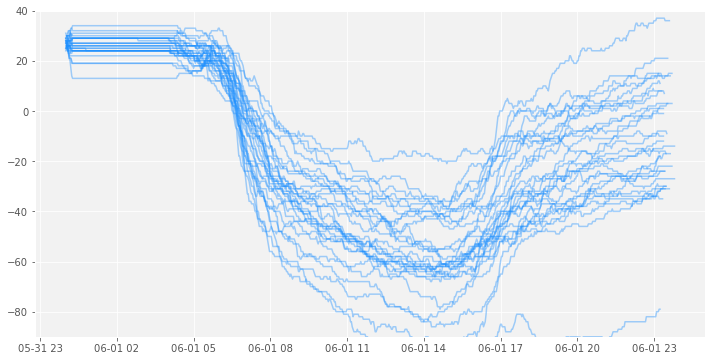

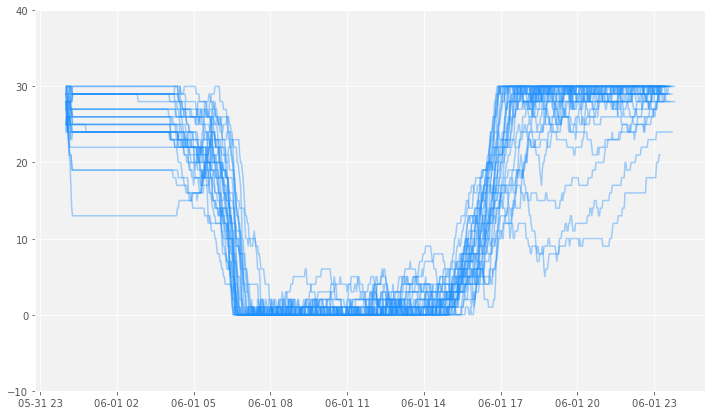

In [611]:
realizations, inds, realizations_finite = sim_station(ar_adj, dep_adj, days_ = 29)

In [612]:
inds = [x for subset in inds for x in subset]
realizations = [x for subset in realizations for x in subset]
realizations = pd.Series(realizations)
realizations.index = inds
inds_finite = inds #[x for subset in inds for x in subset]
realizations_finite = [x for subset in realizations_finite for x in subset]
realizations_finite = pd.Series(realizations_finite)
realizations_finite.index = inds_finite
realizations_finite_data = pd.DataFrame(realizations_finite)
realizations_finite_data.columns = ['occ']

In [613]:
def estimate_adjusted_rate_sim(data, step_size, silent = False):
    pb_weekdays = data
    diff = pb_weekdays.diff()
    diff[diff.isnull()] = 0
    pb_weekdays['difference'] = diff
    pb_weekdays['difference'] = [x for x in pb_weekdays.difference]
    pb_weekdays['maxval'] = [2 if x == 30 else 0 for x in pb_weekdays.occ]
    pb_weekdays['minval'] = [2 if x == 0 else 0 for x in pb_weekdays.occ]
    pb_weekdays['sum_diffs_arr'] = [x if x > 0 else 0 for x in pb_weekdays.difference]
    pb_weekdays['sum_diffs_dep'] = [x if x < 0 else 0 for x in pb_weekdays.difference]
    pb_weekdays['valid_arr_time'] = [2 if y == 0 else 0 for y in pb_weekdays.maxval]
    pb_weekdays['valid_dep_time'] = [2 if y == 0 else 0 for y in pb_weekdays.minval]

    pb_weekdays = pd.DataFrame(pb_weekdays.resample(str(step_size)+'T').sum())
    pb_weekdays['time'] = pb_weekdays.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
    pb_weekdays['arr_rate'] = pb_weekdays.sum_diffs_arr / (pb_weekdays.valid_arr_time / 60)
    pb_weekdays['dep_rate'] = pb_weekdays.sum_diffs_dep / (pb_weekdays.valid_dep_time / 60)
    pb_weekdays[pb_weekdays['arr_rate'].isnull()] = 0
    pb_weekdays[pb_weekdays['arr_rate'] == np.inf] = 0
    pb_weekdays[pb_weekdays['dep_rate'].isnull()] = 0
    pb_weekdays[pb_weekdays['dep_rate'] == np.inf] = 0
    pb_weekdays[pb_weekdays['arr_rate'] == -np.inf] = 0
    pb_weekdays[pb_weekdays['dep_rate'] == -np.inf] = 0
    diff_arr_12 = pb_weekdays.groupby('time').agg('mean')['arr_rate'][1:]
    diff_dep_12 = -pb_weekdays.groupby('time').agg('mean')['dep_rate'][1:]
    diff_arr_12['00:00'] = 0
    diff_dep_12['00:00'] = 0
    diff_arr_12['23:30'] = diff_arr_12['23:00'].copy()
    diff_dep_12['23:30'] = diff_dep_12['23:00'].copy()
    if not silent:
        figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
        ax1.set_ylabel('rate (events per hour)')
        ax1.set_title('Arrival rate. Interval: {} min'.format(step_size))
        diff_arr_12.plot(alpha=0.7, color = 'dodgerblue', ax = ax1)
        ax2.set_title('Departure rate. Interval: {} min'.format(step_size))
        ax2.set_ylabel('rate (events per hour)')
        diff_dep_12.plot(alpha=0.7, color = 'dodgerblue', ax=ax2)
    return diff_arr_12, diff_dep_12

In [632]:
arr_adj_hat, dep_adj_hat = estimate_adjusted_rate_sim(realizations_finite_data, '15', silent = True)

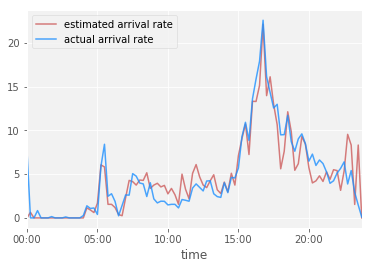

In [615]:
arr_adj_hat.plot(alpha = 0.8, color = 'indianred')
ar_adj.plot(alpha = 0.8, color = 'dodgerblue')
plt.legend(['estimated arrival rate', 'actual arrival rate']);

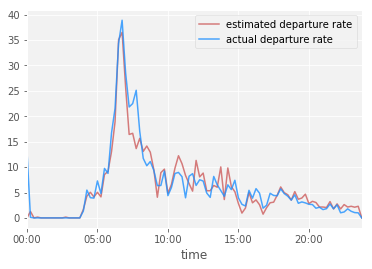

In [616]:
dep_adj_hat.plot(alpha = 0.8, color = 'indianred')
dep_adj.plot(alpha = 0.8, color = 'dodgerblue')
plt.legend(['estimated departure rate', 'actual departure rate']);

# Predicting actual demand by observed occupancy

In [685]:
days = np.unique(realizations_finite.index.date)
day = realizations_finite[realizations_finite.index.date == days[0]]

arr_adj_hat, dep_adj_hat = estimate_adjusted_rate_sim(realizations_finite_data, '15', silent = True)

arr_adj_hat.index = [datetime.datetime.strptime(x, '%H:%M') for x in arr_adj_hat.index]
dep_adj_hat.index = [datetime.datetime.strptime(x, '%H:%M') for x in dep_adj_hat.index]
arr_rate = arr_adj_hat[arr_adj_hat.index.time >= day.index[np.min(np.where(realizations_finite == 0))-1].time()]
dep_rate = dep_adj_hat[dep_adj_hat.index.time >= day.index[np.min(np.where(realizations_finite == 0))-1].time()]
arrival_times = []
for hour in range(len(arr_rate)):
    n_arrivals = np.random.poisson(lam=arr_rate[hour%len(arr_rate)]*24/len(arr_rate))# * np.max([1+np.random.normal(0, 0.5), 0.0001]))  
    for x in range(n_arrivals):
        arrival_times = np.append(arrival_times, np.random.uniform() + hour)
arrival_times = sorted(arrival_times)
departure_times = []
for hour in range(len(dep_rate)):
    n_departures = np.random.poisson(lam=dep_rate[hour%len(dep_rate)]*24/len(dep_rate))#* np.max([1+np.random.normal(0, 0.5), 0.0001]))
    for x in range(n_departures):
        departure_times = np.append(departure_times, np.random.uniform() + hour)
        
departure_times = sorted(departure_times)
arr = pd.DataFrame(arrival_times)
arr['arr'] = np.ones(len(arrival_times))
dep = pd.DataFrame(departure_times)
dep['arr'] = [-x for x in np.ones(len(departure_times))]
arr = arr.append(dep).sort_values(by = 0)

start = 0
occupancy = start + np.cumsum(arr['arr'])
arr['occupancy'] = occupancy        
arr = arr.reset_index(drop=True)

result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(arr_adj_hat)*24]
for j, x in enumerate(result):
    if '60' in x:
        result[j] = x.replace('60', '59')
    if '24:' in x:
        result[j] = ('23:59')
        
result = [datetime.datetime.strptime(x, '%H:%M') for x in result]
result = [x + datetime.timedelta(hours =  day.index[202].hour, minutes = day.index[202].minute) for x in result]

arr.index = [datetime.datetime.strftime(x, '%H:%M') for x in result]
arr.index = pd.to_datetime(arr.index)
arr1 = arr['occupancy'].resample('2T').mean().bfill()
inds.append(ind)
arr1 = arr1.apply(lambda x: round(x, 0))
arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=2))

In [76]:
datetime.timedelta(hours=6)

datetime.timedelta(0, 21600)

NameError: name 'realizations' is not defined

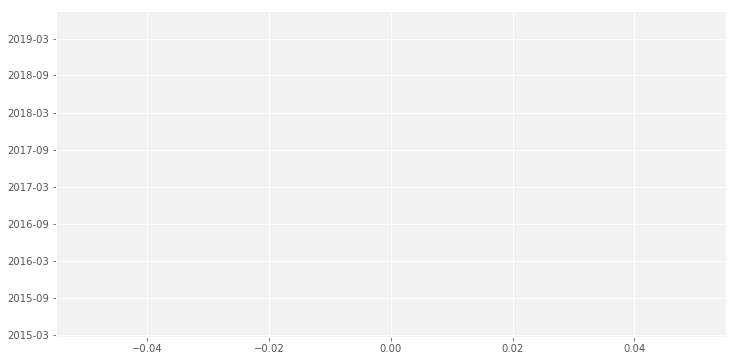

In [66]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.plot(day, color = 'dodgerblue', alpha = 0.5)
plt.plot(realizations[realizations.index.date == days[0]], color = 'hotpink', alpha = 0.5)
plt.plot(arr1, color = 'indianred')
plt.legend(['observed occupancy', 'actual demand', 'estimated demand'])
plt.title('Predicting actual demand by observed occupancy')
plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
fig.savefig('demand_prediction.png')

In [764]:
true_demand = realizations[(realizations.index.date == days[0])&(realizations.index.time >= arr1.index.time[0])]

In [776]:
predicted_demand = [x for x,y in zip(predicted_demand, predicted_demand.index) if y in true_demand.index]

In [778]:
rmse = np.sqrt(mean_squared_error(y_true=true_demand, y_pred = predicted_demand))
print('RMSE:', rmse)

RMSE: 5.782311798970976


In [77]:
data1 = data.resample('2H').last().bfill()

In [78]:
ys = data.resample('2H').last().bfill()

### Training models

In [79]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

def model_report(model, X_train, y_train, X_test, y_test, best_alpha = False):
    model_fit = model.fit(X_train, y_train)
    train_pred = model_fit.predict(X_train)
    test_pred = model_fit.predict(X_test)
    print("MSE train:", mean_squared_error(y_train, train_pred))
    print("R^2 train",r2_score(y_train, train_pred))
    print("MSE test:",mean_squared_error(y_test, test_pred))
    print("R^2 test:",r2_score(y_test, test_pred))
    if best_alpha:
        print("Best alpha:", model_fit.alpha_)

In [80]:
X = features.resample('2H').mean()
y = data['PORTOBELLO_ROAD'].resample('2H').last().bfill()
#y_lag = [[0]]
#y_lag.append([x for x in y[1:].values]) нужно же для каждого дня своё, а не просто шифт на 1
#X['y_lag'] = [x for subset in y_lag for x in subset ]

In [81]:
svr = SVR(kernel = 'rbf')
ridge = RidgeCV(alphas = [0.5, 0.9, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
preds = svr.fit(X_train, y_train).predict(X_test)

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
from sklearn.metrics import mean_squared_error

In [524]:
model_report(ridge, X_train, y_train, X_test, y_test)

MSE train: 111.92365764071643
R^2 train 0.05971663154795759
MSE test: 107.52465714666309
R^2 test: 0.06316177233281983


In [28]:
import missingno as msno
msno.matrix(df.iloc[:,:34])

NameError: name 'df' is not defined

In [29]:
msno.matrix(df.iloc[:,34:-34])

NameError: name 'df' is not defined

In [30]:
msno.matrix(df.iloc[:,-34:])

NameError: name 'df' is not defined

# More fancy graphs

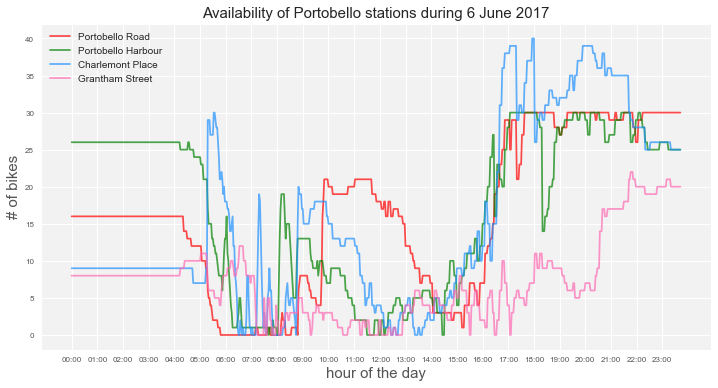

In [91]:
range_ = range(6, 7)
colors = ['black', 'red']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(12, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.7, color = 'r')

for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_HARBOUR'].values, alpha = 0.7, color = 'g')
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['CHARLEMONT_PLACE'].values, alpha = 0.7, color = 'dodgerblue')
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['GRANTHAM_STREET'].values, alpha = 0.7, color = 'hotpink')
                  
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 8)

plt.ylabel('# of bikes')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(15)
axis_weekdays.yaxis.label.set_fontsize(15)
axis_weekdays.legend(['Portobello Road', 'Portobello Harbour', 'Charlemont Place', 'Grantham Street'])

plt.title('Availability of Portobello stations during 6 June 2017')
axis_weekdays.title.set_fontsize(15)

figure.savefig('Portobello_stations.png')
plt.show()

In [63]:
data['DATE'] = [x.date() for x in data.index]
data.columns = [x.replace("'",'') for x in data.columns.values]
dates = []
station_was_empty_3by2mins = []
station_was_full_3by2mins = []
for day in data.DATE.unique():
    dates.append(day)
    df_day = data[data.DATE == day]
    counter_stations_full = 0
    counter_stations_empty = 0
    for name, capacity in zip(stations.Name, stations.Capacity):
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == capacity].shape[0] > 45:
            counter_stations_full += 1
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == 0].shape[0] > 45:
            counter_stations_empty += 1
    station_was_full_3by2mins.append(counter_stations_full)
    station_was_empty_3by2mins.append(counter_stations_empty)   

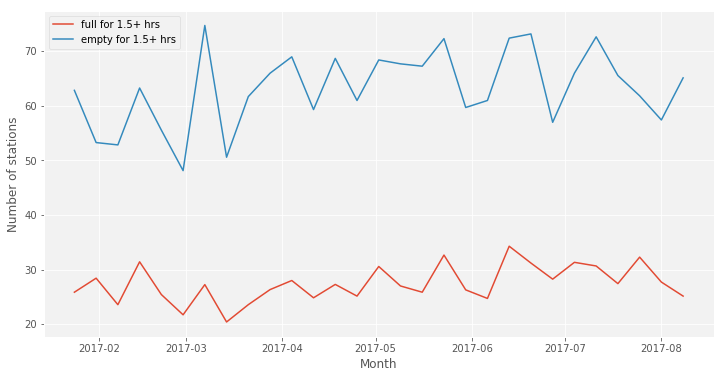

In [64]:
dff = pd.DataFrame({'full': station_was_full_3by2mins, 'empty': station_was_empty_3by2mins})
dff.index = pd.DatetimeIndex(dates)
dff = dff.sort_index(ascending=True)
dff['weekday'] = [x.weekday() for x in dff.index]
dff_week = dff[dff.weekday < 5]
dff_weekend = dff[dff.weekday >= 5]
dff = dff.resample('7D').mean().bfill()

fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'])
plt.plot(dff['empty'])
plt.legend(labels = ['full for 1.5+ hrs', 'empty for 1.5+ hrs'])
plt.xlabel('Month')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');

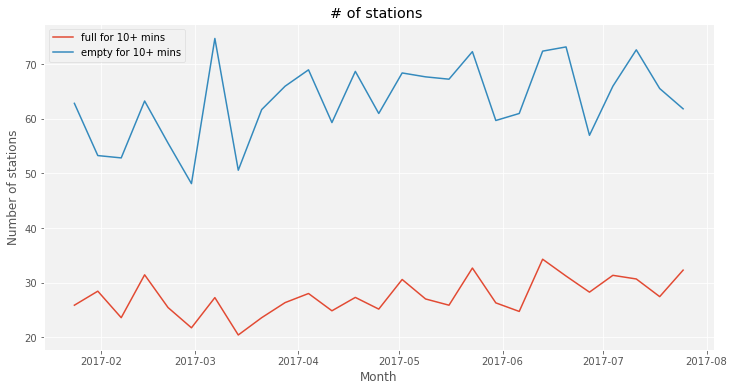

In [65]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'][:-2])
plt.plot(dff['empty'][:-2])
plt.legend(labels = ['full for 10+ mins', 'empty for 10+ mins'])
plt.xlabel('Month')
plt.title('# of stations ')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');